In [1]:
import sklearn
from sklearn.datasets import make_circles
import torch 
from torch import nn
import matplotlib.pyplot as plt

In [2]:
n_samples = 3000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

In [3]:
len(X), len(y)

(3000, 3000)

In [4]:
import pandas as pd

circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})

In [5]:
circles.head()

,X1,X2,label
0,0.204614,0.744496,1
1,0.240364,-0.972271,0
2,0.231681,0.765188,1
3,0.485038,0.867620,0
4,-0.397572,-0.703067,1


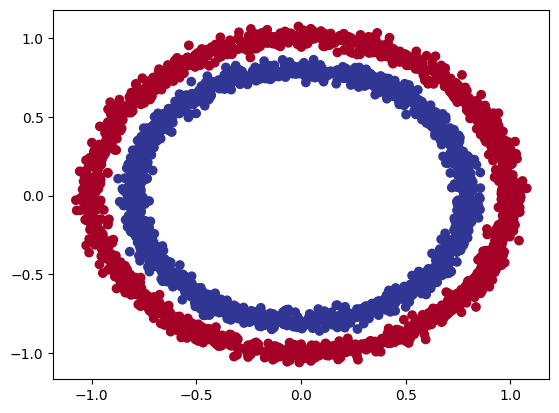

In [6]:
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)
plt.show()

In [7]:
X.shape, y.shape

((3000, 2), (3000,))

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
X.dtype, y.dtype

(torch.float64, torch.int64)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2400, 600, 2400, 600)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [14]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer1 = nn.Linear(
        in_features=2,
        out_features=50
    )
    self.linear_layer2 = nn.Linear(
        in_features=50,
        out_features=100
    )
    self.linear_layer3 = nn.Linear(
        in_features=100,
        out_features=1
    )

  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))

model = CircleModel().to(device)
model

CircleModel(
  (linear_layer1): Linear(in_features=2, out_features=50, bias=True)
  (linear_layer2): Linear(in_features=50, out_features=100, bias=True)
  (linear_layer3): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
next(model.parameters()).device

device(type='cuda', index=0)

In [16]:
model.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.3607, -0.3713],
                      [-0.5507,  0.4372],
                      [ 0.4602,  0.3897],
                      [-0.4440, -0.0368],
                      [-0.2137, -0.5477],
                      [-0.5504, -0.1171],
                      [-0.0562, -0.3101],
                      [ 0.2293, -0.0912],
                      [-0.1382, -0.0126],
                      [ 0.5247, -0.3593],
                      [-0.4602,  0.3158],
                      [ 0.4472,  0.1556],
                      [ 0.2567, -0.4126],
                      [-0.6764, -0.5871],
                      [-0.5380, -0.3742],
                      [-0.5986, -0.3390],
                      [-0.0248,  0.2613],
                      [ 0.3387, -0.3967],
                      [ 0.2066, -0.6293],
                      [ 0.6925,  0.4328],
                      [-0.0512,  0.4658],
                      [-0.3347, -0.2682],
                      [ 0.4651,  0.601

In [17]:
with torch.inference_mode():
  y_logits = model(X_test.type(torch.float))

torch.round(y_logits[:10])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [18]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob[:10]

tensor([[0.5405],
        [0.5311],
        [0.5456],
        [0.5412],
        [0.5324],
        [0.5338],
        [0.5284],
        [0.5143],
        [0.5287],
        [0.5341]], device='cuda:0')

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01,
    momentum=0.9
)

In [20]:
!pip install torchmetrics

import torchmetrics
accuracy = torchmetrics.Accuracy(task='binary', num_classes=2).to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
torch.manual_seed(42)

epochs = 100

X_train = X_train.type(torch.float).to(device)
X_test = X_test.type(torch.float).to(device)
y_train = y_train.type(torch.float).to(device)
y_test = y_test.type(torch.float).to(device)

for epoch in range(epochs):
  model.train()
  train_logits = model(X_train).squeeze()
  train_pred = torch.round(torch.sigmoid(train_logits))
  loss = loss_fn(train_logits, y_train)
  acc = accuracy(train_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(test_pred, y_test)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Accuracy: {acc} | Loss: {loss} | Test Loss: {test_loss} | Test Accuracy: {test_acc}')

Epoch: 0 | Accuracy: 0.49958333373069763 | Loss: 0.6951206922531128 | Test Loss: 0.6943421959877014 | Test Accuracy: 0.5016666650772095
Epoch: 10 | Accuracy: 0.5074999928474426 | Loss: 0.693191647529602 | Test Loss: 0.6934507489204407 | Test Accuracy: 0.4883333444595337
Epoch: 20 | Accuracy: 0.5004166960716248 | Loss: 0.6933234333992004 | Test Loss: 0.6941319704055786 | Test Accuracy: 0.4983333349227905
Epoch: 30 | Accuracy: 0.5054166913032532 | Loss: 0.6930683851242065 | Test Loss: 0.693810760974884 | Test Accuracy: 0.4866666793823242
Epoch: 40 | Accuracy: 0.518750011920929 | Loss: 0.6930974721908569 | Test Loss: 0.6938166618347168 | Test Accuracy: 0.49000000953674316
Epoch: 50 | Accuracy: 0.5041666626930237 | Loss: 0.6930690407752991 | Test Loss: 0.6938733458518982 | Test Accuracy: 0.476666659116745
Epoch: 60 | Accuracy: 0.4970833361148834 | Loss: 0.6930714845657349 | Test Loss: 0.6938570141792297 | Test Accuracy: 0.4716666638851166
Epoch: 70 | Accuracy: 0.5045833587646484 | Loss: 0.

In [22]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=50)
    self.linear2 = nn.Linear(in_features=50, out_features=100)
    self.linear3 = nn.Linear(in_features=100, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (linear1): Linear(in_features=2, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

In [24]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [25]:
epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(test_pred, y_test)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch:.2f} | Accuracy: {acc:.2f} | Loss: {loss:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0.00 | Accuracy: 0.50 | Loss: 0.69 | Test Loss: 0.69 | Test Accuracy: 0.50
Epoch: 100.00 | Accuracy: 0.68 | Loss: 0.67 | Test Loss: 0.68 | Test Accuracy: 0.67
Epoch: 200.00 | Accuracy: 0.85 | Loss: 0.65 | Test Loss: 0.65 | Test Accuracy: 0.84
Epoch: 300.00 | Accuracy: 0.96 | Loss: 0.58 | Test Loss: 0.58 | Test Accuracy: 0.96
Epoch: 400.00 | Accuracy: 1.00 | Loss: 0.45 | Test Loss: 0.45 | Test Accuracy: 0.99
Epoch: 500.00 | Accuracy: 1.00 | Loss: 0.27 | Test Loss: 0.27 | Test Accuracy: 1.00
Epoch: 600.00 | Accuracy: 1.00 | Loss: 0.15 | Test Loss: 0.15 | Test Accuracy: 1.00
Epoch: 700.00 | Accuracy: 1.00 | Loss: 0.09 | Test Loss: 0.09 | Test Accuracy: 1.00
Epoch: 800.00 | Accuracy: 1.00 | Loss: 0.06 | Test Loss: 0.06 | Test Accuracy: 1.00
Epoch: 900.00 | Accuracy: 1.00 | Loss: 0.04 | Test Loss: 0.04 | Test Accuracy: 1.00
